In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten,Input
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from keras.callbacks import ModelCheckpoint
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import display, HTML

### iterate through the folders to create a dataframe of the form filepaths labels

In [18]:
sdir=r'/Users/nirwanaamir/Downloads/dataset-2'


filepaths=[]
labels=[]
classlist=os.listdir(sdir)
for klass in classlist:
    classpath=os.path.join(sdir,klass)
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)                   
Fseries= pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')    
df=pd.concat([Fseries, Lseries], axis=1)
print (df.head())
print (df['labels'].value_counts())

                                           filepaths              labels
0  /Users/nirwanaamir/Downloads/dataset-2/Ayam Wo...  Ayam Woku (Manado)
1  /Users/nirwanaamir/Downloads/dataset-2/Ayam Wo...  Ayam Woku (Manado)
2  /Users/nirwanaamir/Downloads/dataset-2/Ayam Wo...  Ayam Woku (Manado)
3  /Users/nirwanaamir/Downloads/dataset-2/Ayam Wo...  Ayam Woku (Manado)
4  /Users/nirwanaamir/Downloads/dataset-2/Ayam Wo...  Ayam Woku (Manado)
labels
Ayam Woku (Manado)             50
Mie Titi(Makassar)             50
Deppa Tori_ (Toraja)           50
Konro (Makassar)               50
Coto Makassar (Makassar)       50
Pisang Ijo (Makassar)          50
Kasuami (Wakatobi)             50
Kue Tetu(Sulawesi Barat)       50
Cakalang Pampis (Manado)       50
Bubur Manado (Manado)          50
Lawa Bale (Palopo)             50
Panada (Sulawesi  Utara)       50
Kapurung (Palopo)              50
Barongko (Sulawesi Selatan)    50
Nasu Palekko (Pinrang)         50
Lalampa(Sulawesi Tengah)       50
Pa_piong (T

### split df into train_df, test_df and valid_df

In [19]:
train_split=.7
test_split=.2
dummy_split=test_split/(1-train_split)
train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print ('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df length:  700   test_df length:  200   valid_df length:  100


### create train, test, valid  generators

In [20]:
height=224
width=224
channels=3
batch_size=64
img_shape=(height, width, channels)
img_size=(height, width)

length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)

gen=ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, rotation_range=30, horizontal_flip=True)


train_gen=gen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

validgen=ImageDataGenerator(rescale=1./255)
valid_gen=validgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

testgen=ImageDataGenerator(rescale=1./255)
test_gen=testgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)

classes=list(train_gen.class_indices.keys())
print (classes)
class_count=len(classes)



test batch size:  50   test steps:  4
Found 700 validated image filenames belonging to 20 classes.
Found 100 validated image filenames belonging to 20 classes.
Found 200 validated image filenames belonging to 20 classes.
['Ayam Woku (Manado)', 'Barongko (Sulawesi Selatan)', 'Bubur Manado (Manado)', 'Cakalang Pampis (Manado)', 'Coto Makassar (Makassar)', 'Deppa Tori_ (Toraja)', 'Jagung Marning (Bulukumba)', 'Kapurung (Palopo)', 'Kasuami (Wakatobi)', 'Konro (Makassar)', 'Kue Tetu(Sulawesi Barat)', 'Lalampa(Sulawesi Tengah)', 'Lapa-Lapa (Buton)', 'Lawa Bale (Palopo)', 'Mie Titi(Makassar)', 'Nasu Palekko (Pinrang)', 'Pa_piong (Toraja)', 'Panada (Sulawesi  Utara)', 'Pisang Ijo (Makassar)', 'klappertaart (Manado)']


### create function to show some image examples

In [21]:
def show_image_samples_filenames(gen):
    filenames = gen.filenames
    print("Filenames of images in the testing dataset:")
    for filename in filenames:
        print(filename)

# Display filenames of images in the testing dataset
show_image_samples_filenames(test_gen)


Filenames of images in the testing dataset:
/Users/nirwanaamir/Downloads/dataset-2/Kasuami (Wakatobi)/38.png
/Users/nirwanaamir/Downloads/dataset-2/Pa_piong (Toraja)/48.png
/Users/nirwanaamir/Downloads/dataset-2/Kue Tetu(Sulawesi Barat)/34.jpg
/Users/nirwanaamir/Downloads/dataset-2/klappertaart (Manado)/3.png
/Users/nirwanaamir/Downloads/dataset-2/Barongko (Sulawesi Selatan)/38.jpg
/Users/nirwanaamir/Downloads/dataset-2/Konro (Makassar)/25.jpg
/Users/nirwanaamir/Downloads/dataset-2/Cakalang Pampis (Manado)/15.png
/Users/nirwanaamir/Downloads/dataset-2/Kapurung (Palopo)/35.png
/Users/nirwanaamir/Downloads/dataset-2/Konro (Makassar)/1.jpg
/Users/nirwanaamir/Downloads/dataset-2/Nasu Palekko (Pinrang)/34.jpg
/Users/nirwanaamir/Downloads/dataset-2/Lalampa(Sulawesi Tengah)/13.jpg
/Users/nirwanaamir/Downloads/dataset-2/Pisang Ijo (Makassar)/25.jpg
/Users/nirwanaamir/Downloads/dataset-2/Konro (Makassar)/36.jpg
/Users/nirwanaamir/Downloads/dataset-2/Lawa Bale (Palopo)/36.jpg
/Users/nirwanaamir/

### create the model

In [22]:
base_model=tf.keras.applications.Xception(include_top=False, weights="imagenet",input_tensor=Input(shape=(224,224,3))) 

In [23]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_2[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 111, 111, 32)         0         ['block1_conv1_bn[0][0]

In [24]:
base_model.trainable = False

In [25]:
model_name='Cendekia'
print("Building model with", base_model)
model = tf.keras.Sequential([
            # Note the input shape is the desired size of the image 128x128 with 3 bytes color
            # This is the first convolution
            base_model,
            tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
            tf.keras.layers.Dropout(rate=0.5),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(20, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=.001), loss='categorical_crossentropy', metrics='accuracy')

Building model with <keras.src.engine.functional.Functional object at 0x2942892b0>


In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 3, 3, 2048)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 3, 3, 2048)        0         
                                                                 
 flatten_1 (Flatten)         (None, 18432)             0         
                                                                 
 dense_1 (Dense)             (None, 20)                368660    
                                                                 
Total params: 21230140 (80.99 MB)
Trainable params: 368660 (1.41 MB)
Non-trainable params: 20861480 (79.58 MB)
_________

In [27]:
epochs = 50

history=model.fit(x=train_gen, epochs=epochs, validation_data=valid_gen)

Epoch 1/50
11/11 [==============================] - 142s 12s/step - loss: 7.1902 - accuracy: 0.2857 - val_loss: 1.0275 - val_accuracy: 0.5800
Epoch 2/50
11/11 [==============================] - 180s 16s/step - loss: 1.1391 - accuracy: 0.6871 - val_loss: 1.0664 - val_accuracy: 0.7300
Epoch 3/50
11/11 [==============================] - 167s 15s/step - loss: 0.8020 - accuracy: 0.7643 - val_loss: 0.6994 - val_accuracy: 0.7900
Epoch 4/50
11/11 [==============================] - 157s 14s/step - loss: 0.7926 - accuracy: 0.8043 - val_loss: 1.1013 - val_accuracy: 0.7500
Epoch 5/50
11/11 [==============================] - 145s 13s/step - loss: 0.5562 - accuracy: 0.8543 - val_loss: 0.6711 - val_accuracy: 0.8100
Epoch 6/50
11/11 [==============================] - 171s 15s/step - loss: 0.5770 - accuracy: 0.8457 - val_loss: 0.8527 - val_accuracy: 0.8100
Epoch 7/50
11/11 [==============================] - 159s 14s/step - loss: 0.4422 - accuracy: 0.8829 - val_loss: 0.8607 - val_accuracy: 0.8000
Epoch 

### define function to print text in RGB foreground and background colors

In [28]:
def print_in_color(txt_msg, fore_tupple, back_tupple):
    # prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple
    # text_msg is the text, fore_tupple is foregroud color tuple (r, g, b), back_tupple is background tuple (r, g, b)
    rf, gf, bf = fore_tupple
    rb, gb, bb = back_tupple
    msg = '{0}' + txt_msg
    mat = '\33[38;2;' + str(rf) + ';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' + str(gb) + ';' + str(
        bb) + 'm'
    print(msg.format(mat), flush=True)
    print('\33[0m', flush=True)  # returns default print color to back to black
    return

### define function to plot the training data

In [29]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()


### define function to generate the confusion matrix and classification report

In [30]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'  
    dict_path=os.path.join(save_dir,dict_name)    
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)    
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)        
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):                
                split1=os.path.split(error_list[i])                
                split2=os.path.split(split1[0])                
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class 
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)        
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # create a confusion matrix 
        cm = confusion_matrix(y_true, y_pred )        
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

### evaluate model on the test set then save the model

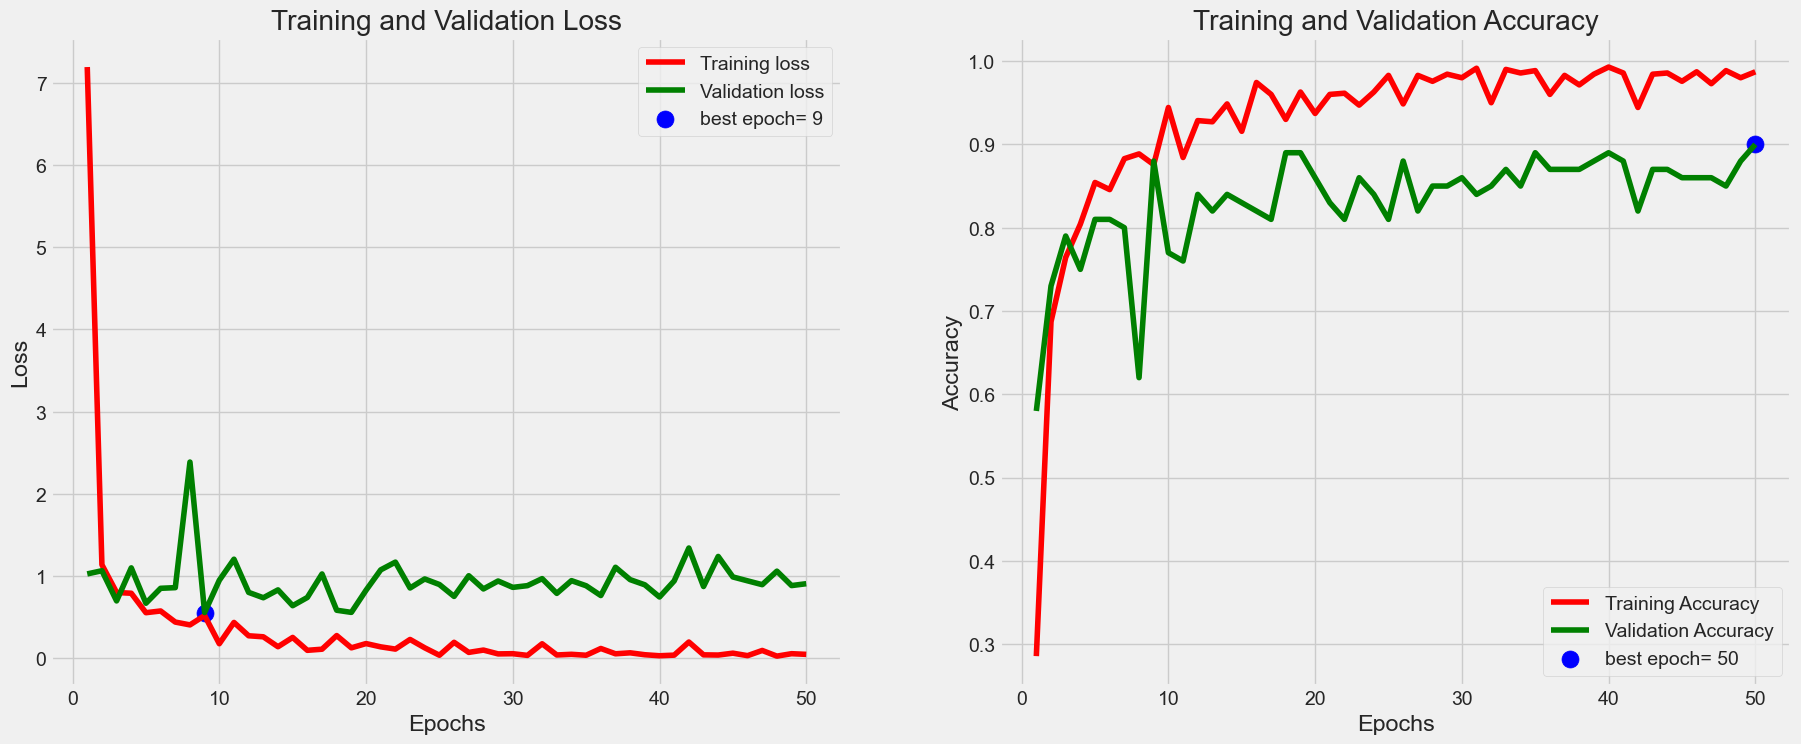

4/4 [==============================] - 38s 8s/step - loss: 1.1438 - accuracy: 0.8250
Accuracy on the test set is 82.50%, Test Loss: 1.1438, Validation Loss: 0.9086, Validation Accuracy: 0.9000



/Users/nirwanaamir/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [31]:
tr_plot(history,0)
save_dir=r'./'
subject='Skenario4'
test_results = model.evaluate(test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=True)

# Extract the relevant metrics
test_loss = test_results['loss']
test_accuracy = test_results['accuracy']
val_loss = history.history['val_loss'][-1]
val_accuracy = history.history['val_accuracy'][-1]

# Print the results in color
msg = f'Accuracy on the test set is {test_accuracy * 100:.2f}%, Test Loss: {test_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}'
print_in_color(msg, (0, 255, 0), (55, 65, 80))

# Save the model
save_id = str(model_name + '-' + subject + '-' + str(test_accuracy * 100)[:str(test_accuracy * 100).rfind('.') + 3] + '.h5')
save_loc = os.path.join(save_dir, save_id)
model.save(save_loc)

### make predictions on test set and generate confusion matrix and classification report

4/4 [==============================] - 46s 9s/step


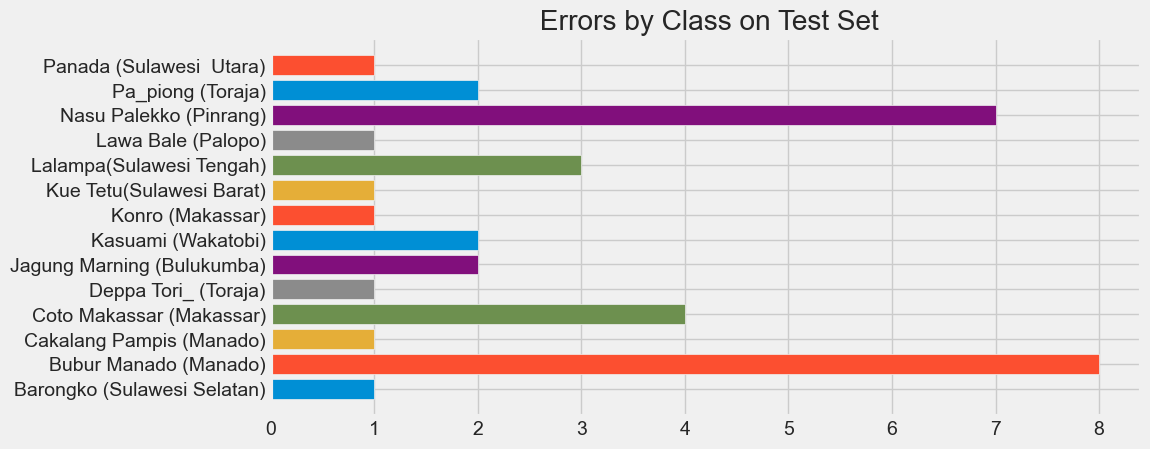

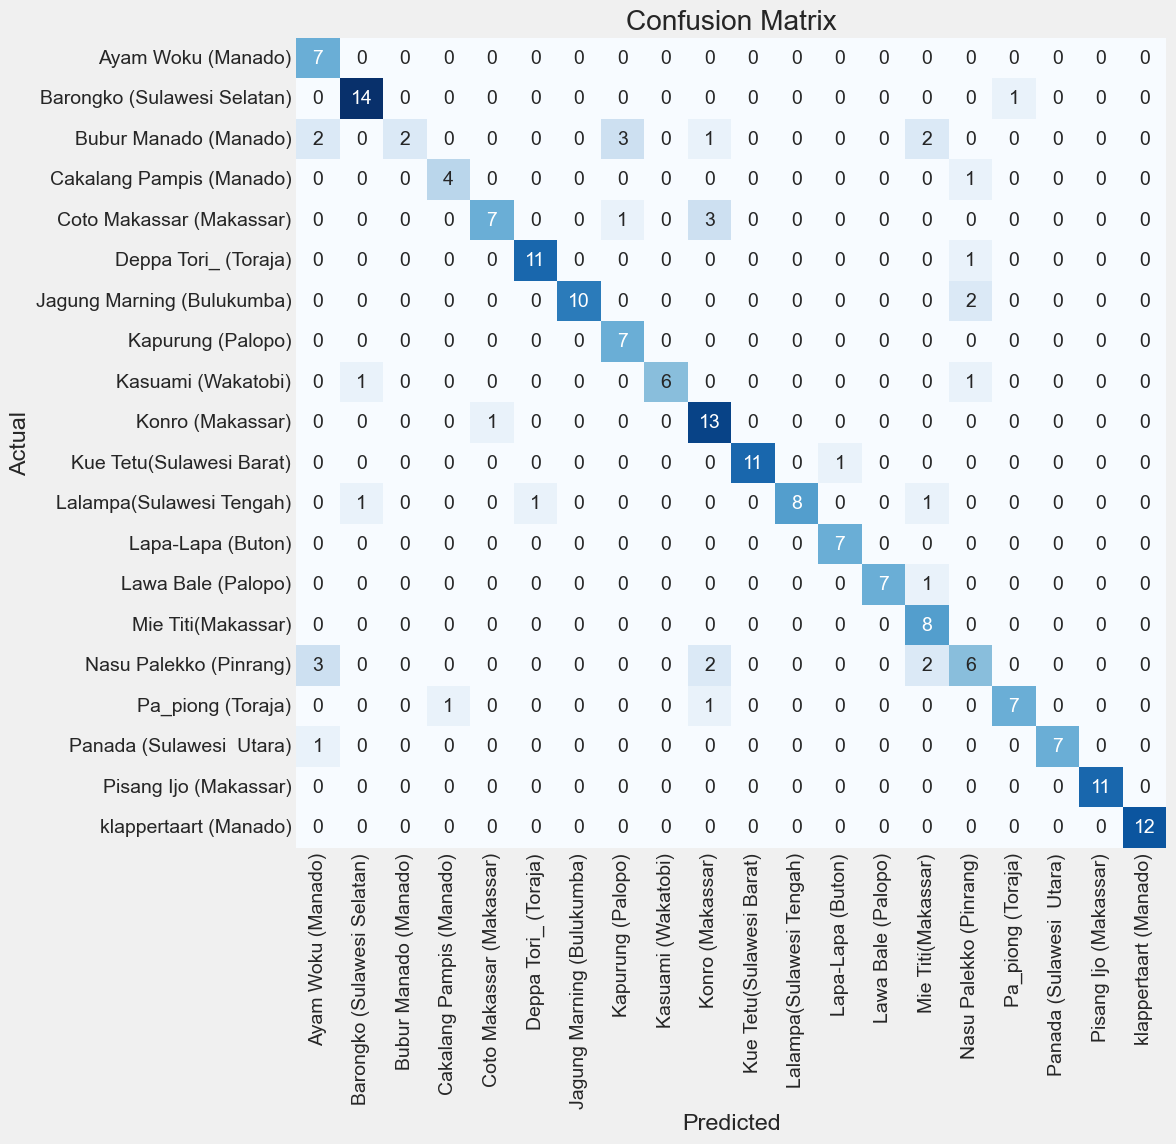

Classification Report:
----------------------
                              precision    recall  f1-score   support

         Ayam Woku (Manado)       0.54      1.00      0.70         7
Barongko (Sulawesi Selatan)       0.88      0.93      0.90        15
      Bubur Manado (Manado)       1.00      0.20      0.33        10
   Cakalang Pampis (Manado)       0.80      0.80      0.80         5
   Coto Makassar (Makassar)       0.88      0.64      0.74        11
       Deppa Tori_ (Toraja)       0.92      0.92      0.92        12
 Jagung Marning (Bulukumba)       1.00      0.83      0.91        12
          Kapurung (Palopo)       0.64      1.00      0.78         7
         Kasuami (Wakatobi)       1.00      0.75      0.86         8
           Konro (Makassar)       0.65      0.93      0.76        14
   Kue Tetu(Sulawesi Barat)       1.00      0.92      0.96        12
   Lalampa(Sulawesi Tengah)       1.00      0.73      0.84        11
          Lapa-Lapa (Buton)       0.88      1.00      0

In [32]:
print_code=0
preds=model.predict(test_gen) 
print_info( test_gen, preds, print_code, save_dir, subject )  